<div align="center"> 
<img src='./img/header.png'/>
</div>

## [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days


---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://staging.nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at uso@nsidc.org


In [ ]:
#1: We are importing the its_live class and supresing non essential warnings
from itslive import itslive_ui
ui = itslive_ui('north')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#2: Now let's render our UI and pick up an hemisphere, if you update the hemisphere you need to execute the cell again.
ui.render()
#TODO: change 30 to 33, 7 to 17
# multiples of 16+1

In [ ]:
#3: We build the parameters to query the ITS_LIVE Search API, we get the time coverage for our selected area
params = ui.build_params()
print(f'current parameters: {params}')
timeline = None
if params is not None:
    timeline = ui.update_coverages()
    total =  sum(item['count'] for item in timeline)
    print(f'Total data granules: {total:,}')
timeline

In [ ]:
#4: Now we are going to get the velocity pair urls
params = ui.build_params()
if params is not None:
    urls = ui.get_granule_urls()
    # Print the first 10 granule URLs
    for url in urls:
        print(url)

In [ ]:
#5: This will query AWS(where the granules are stored) so we know the total size of our first N granules
# This may take some time, try reducing the selected area or constraining the other parameters to download a reasonable number of granules.
max_granules = 100
sizes = ui.calculate_file_sizes(max_granules)
total_zise = round(sum(sizes)/1024,2)
print(f'Approx size to download for the first {max_granules:,} granules: {total_zise} MB')

## Downloading the data
**Now that we have our list of data granules we can download them from AWS.**

If this notebook is running inside AWS we could load the granules into a Dask cluster and reduce our processing times and costs.
Let's get some coffee, some data requests are in the Gigabytes realm and may take a little while to be processed. 
Once that your status URL says is completed we can grab the HDF5 data file using the URL on the same response!

In [ ]:
files = ui.download_velocity_pairs(0,100)
files

## Working with the data

In [5]:
import os
import glob
import xarray as xr

# ds = xr.open_mfdataset('data*/*.nc', combine='by_coords')
# ds_0 = xr.open_dataset('data/' + files[0])

# mask_lon = (ds_0.x >= 500000) & (ds_0.x <= 550000)
# mask_lat = (ds_0.y >= 7720000) & (ds_0.y <= 7800000) 
ds_stack = []
for file in glob.glob('./data/*'):
    ds =  xr.open_dataset(file)
    mask_lon = (ds.x >= 500000) & (ds.x <= 550000)
    mask_lat = (ds.y >= 7720000) & (ds.y <= 7800000)
    ds_stack.append(ds.where(mask_lon & mask_lat , drop=True))

ds_cube = xr.concat(ds_stack, 'time')


    
    

# ds_0.plot.scatter(x='x',y='y', hue='v', size=8)
# ds_1.plot.scatter(x='x',y='y', hue='v', size=8)


# ds = xr.concat([ds_0, ds_1], 'time')
# ds

# ds_0.where(mask_lon & mask_lat , drop=True).plot.scatter(x='x',y='y', hue='v', size=8)
# ds_1.plot.scatter(x='x',y='y', hue='v', size=8)

SyntaxError: invalid syntax (<ipython-input-5-5098a36c3526>, line 19)

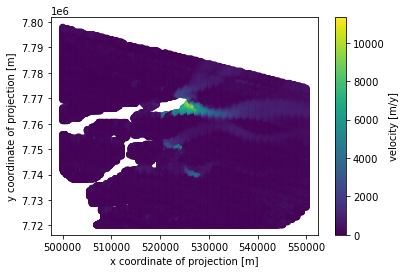

In [21]:
ds_cube.where(ds_cube.x == 1).plot.scatter(x='x', y='y', hue='v')